# MODELADO

## REGRESIÓN LINEAL


<hr>

<code> **Proyecto de Datos II** </code>

## Índice

- [Importación de los datos](#importación-de-los-datos)
- [Preprocesamiento](#preprocesamiento)
- [Entrenamiento](#entrenamiento)
- [Análisis del modelo](#análisis-del-modelo)
- [Registro del modelo en MLflow](#registro-del-modelo-en-mlflow)


In [36]:
import time
import mlflow
import pandas as pd
from evaluation.evaluator import Evaluator

SEED = 22 # replicabilidad

# =====================================
MODEL_NAME = "linear_regression"
# =====================================

## Importación de los datos

In [37]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("app").getOrCreate()
sc = spark.sparkContext

In [45]:
df_train = spark.read.parquet("../data/train_spark.parquet")
df_test = spark.read.parquet("../data/test_spark.parquet")

In [39]:
df_train.count(), df_test.count()

(123733, 27791)

## Preprocesamiento

En primer lugar seleccionamos las columnas según si son numéricas, categóricas o booleanas para posteriormente procesarlas.

In [46]:
from pyspark.sql.types import StringType, BooleanType, NumericType

# Lista de columnas a excluir
cols_to_exclude = ["timestamp", "icao", "callsign", "takeoff_time", "__index_level_0__"]

# Separar columnas en numéricas y categóricas
categorical_cols = [f.name for f in df_train.schema.fields 
                    if isinstance(f.dataType, StringType) and f.name not in cols_to_exclude]

# Columnas numéricas puras (int, double, etc)
numeric_cols = [f.name for f in df_train.schema.fields 
                if isinstance(f.dataType, NumericType) and f.name not in cols_to_exclude]

# Columnas booleanas
boolean_cols = [f.name for f in df_train.schema.fields 
                if isinstance(f.dataType, BooleanType) and f.name not in cols_to_exclude]

Las columnas booleanas se encuentran en formato True/False. Las convertimos a 1/0 para evitar errores posteriores.

In [61]:
from pyspark.sql.functions import col

for col_name in boolean_cols:
    df_train = df_train.withColumn(col_name, col(col_name).cast("integer"))
    df_test = df_test.withColumn(col_name, col(col_name).cast("integer"))

Construimos un pipeline que incluye lo siguiente:
 1. Indexación de las variables categóricas (asigna un entero a cada clase)
 2. One-Hot Encoding de las variables categóricas (una vez han sido indexadas)
 3. Unión de todas las variables categóricas en una sola columna
 4. Indexación de las columnas booleanas
 5. Unión de todas las columnas booleanas en una sola columna
 6. Unión de todas las variables numéricas en una sola columna
 7. Escalado de las variables numéricas
 8. Unión final de todas las variables (numéricas y categóricas) en una sola columna "features" que será el input del modelo

Definimos este pipeline dentro de una función que toma como argumento un modelo de Regresión Lineal. Esto nos facilitará hacer validación cruzada más adelante.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.regression import LinearRegression

def create_pipeline(lr):

    # 1. Indexamos las columnas categóricas (un StringIndexer por cada columna)
    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
        for col in categorical_cols
    ]

    # 2. One-Hot Encoding de categóricas
    encoders = [OneHotEncoder(inputCol=c + "_indexed", outputCol=c + "_ohe") for c in categorical_cols]

    # 3. VectorAssembler para categóricas (después del OneHotEncoder)
    categorical_assembler = VectorAssembler(inputCols=[f"{col}_ohe" for col in categorical_cols], outputCol="categorical_features")

    # 4. Indexadores de columnas booleanas (sin one-hot)
    bool_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in boolean_cols]

    # 5. VectorAssembler para booleanas (no se normalizan)
    boolean_assembler = VectorAssembler(inputCols=[f"{col}_indexed" for col in boolean_cols], outputCol="boolean_features")

    # 6. VectorAssembler para numéricas
    numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")

    # 7. StandardScaler para numéricas
    scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withMean=True, withStd=True)

    # 8. VectorAssembler que junta numéricas escaladas + categóricas
    final_assembler = VectorAssembler(
        inputCols=["scaled_numeric_features", "categorical_features", "boolean_features"],
        outputCol="features",
        handleInvalid="skip"
    )

    # Pipeline
    pipeline = Pipeline(stages=indexers + encoders + bool_indexers + 
                        [numeric_assembler, scaler, categorical_assembler, boolean_assembler, final_assembler, lr])
    
    return pipeline

- Definimos un grid de hiperparámetros de forma manual para escoger los mejores mediante validación cruzada.
- Definimos los evaluadores para las métricas RMSE y MAE.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from itertools import product

# Grid de hiperparámetros manual
reg_params = [0.01, 0.1, 1.0]
elastic_net_params = [0.0, 0.5, 1.0]
max_iters = [50, 100, 200]

param_grid = [
    {"regParam": reg, "elasticNetParam": enet, "maxIter": it}
    for reg, enet, it in product(reg_params, elastic_net_params, max_iters)
]

# Evaluador
evaluator_rmse = RegressionEvaluator(labelCol="takeoff_time", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="takeoff_time", predictionCol="prediction", metricName="mae")

### Validación cruzada expandida (expanding window)
Para hacer validación cruzada correctamente, vamos a dividir manualmente nuestro conjunto de entrenamiento en __5 folds respetando el orden temporal__. Vamos a utilizar _validación cruzada expandida o expanding window_, que consiste en entrenar el modelo con un período creciente de datos y validar en el siguiente punto en el tiempo.

| Fold | Train Period             | Validation Period      |
|------|---------------------------|-------------------------|
| 1    | 07/11/2024 - 30/11/2024    | 01/12/2024 - 07/12/2024 |
| 2    | 07/11/2024 - 07/12/2024    | 08/12/2024 - 14/12/2024 |
| 3    | 07/11/2024 - 14/12/2024    | 15/12/2024 - 21/12/2024 |
| 4    | 07/11/2024 - 21/12/2024    | 22/12/2024 - 28/12/2024 |
| 5    | 07/11/2024 - 28/12/2024    | 29/12/2024 - 04/01/2025 |

In [50]:
# Definimos los folds manualmente
folds = [
    {"train_end": "2024-11-30", "val_start": "2024-12-01", "val_end": "2024-12-07"},
    {"train_end": "2024-12-07", "val_start": "2024-12-08", "val_end": "2024-12-14"},
    {"train_end": "2024-12-14", "val_start": "2024-12-15", "val_end": "2024-12-21"},
    {"train_end": "2024-12-21", "val_start": "2024-12-22", "val_end": "2024-12-28"},
    {"train_end": "2024-12-28", "val_start": "2024-12-29", "val_end": "2025-01-04"},
]

## Entrenamiento

Para el entrenamiento realizamos un bucle que recorre las distintas combinaciones de hiperparámetros, y a su vez entrena y valida con los 5 folds que definimos anteriormente. Realizamos una validación cruzada "manual" debido a la naturaleza de los datos, asegurándonos de que no se van a producir filtraciones temporales. Guardamos las métricas en cada iteración para finalmente poder calcular métricas promedio.

In [51]:
start_time = time.time()

# ========================================
# ENTRENAMIENTO AQUÍ
from pyspark.sql.functions import col

results = [] # rmse y mae medios de cada modelo (con unos hiperparámetros distintos)

# Loop sobre hiperparámetros
for params in param_grid:
    fold_metrics = [] # métricas de cada fold

    for fold in folds:
        # 1. Separar Train y Validation respetando fechas
        train_fold = df_train.filter(col("timestamp") <= fold["train_end"])
        val_fold = df_train.filter((col("timestamp") >= fold["val_start"]) & (col("timestamp") <= fold["val_end"]))
        
        # 2. Definir LinearRegression con hiperparámetros actuales
        lr = LinearRegression(
            featuresCol="features",
            labelCol="takeoff_time",
            regParam=params["regParam"],
            elasticNetParam=params["elasticNetParam"],
            maxIter=params["maxIter"]
        )
        
        # 3. Crear pipeline completo
        pipeline = create_pipeline(lr)  # Esta función la defines tú (tu pipeline que indexa, escala, etc.)
        
        # 4. Entrenar el modelo en el train_fold
        model = pipeline.fit(train_fold)

         # --- Evaluar en TRAIN ---
        train_preds = model.transform(train_fold)
        train_rmse = evaluator_rmse.evaluate(train_preds)
        train_mae = evaluator_mae.evaluate(train_preds)

        # --- Evaluar en VALIDATION ---
        val_preds = model.transform(val_fold)
        val_rmse = evaluator_rmse.evaluate(val_preds)
        val_mae = evaluator_mae.evaluate(val_preds)
        
        fold_metrics.append({
            "train_rmse": train_rmse,
            "train_mae": train_mae,
            "val_rmse": val_rmse,
            "val_mae": val_mae,
        })

    # --- Calcular métricas promedio por param_grid ---
    avg_train_rmse = sum(f["train_rmse"] for f in fold_metrics) / len(fold_metrics)
    avg_train_mae = sum(f["train_mae"] for f in fold_metrics) / len(fold_metrics)
    avg_val_rmse = sum(f["val_rmse"] for f in fold_metrics) / len(fold_metrics)
    avg_val_mae = sum(f["val_mae"] for f in fold_metrics) / len(fold_metrics)

    results.append({
        "params": params,
        "avg_train_rmse": avg_train_rmse,
        "avg_train_mae": avg_train_mae,
        "avg_val_rmse": avg_val_rmse,
        "avg_val_mae": avg_val_mae
    })

    print(f"Params: {params}")
    print(f"Train RMSE: {avg_train_rmse:.3f} | Train MAE: {avg_train_mae:.3f}")
    print(f"Val   RMSE: {avg_val_rmse:.3f} | Val   MAE: {avg_val_mae:.3f}")
    print("-" * 60)
# ========================================

end_time = time.time()
execution_time = end_time - start_time

Params: {'regParam': 0.01, 'elasticNetParam': 0.0, 'maxIter': 50}
Train RMSE: 84.457 | Train MAE: 60.885
Val   RMSE: 107.807 | Val   MAE: 76.113
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 0.0, 'maxIter': 100}
Train RMSE: 84.457 | Train MAE: 60.885
Val   RMSE: 107.807 | Val   MAE: 76.113
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 0.0, 'maxIter': 200}
Train RMSE: 84.457 | Train MAE: 60.885
Val   RMSE: 107.807 | Val   MAE: 76.113
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 0.5, 'maxIter': 50}
Train RMSE: 84.464 | Train MAE: 60.876
Val   RMSE: 107.863 | Val   MAE: 76.162
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 0.5, 'maxIter': 100}
Train RMSE: 84.460 | Train MAE: 60.876
Val   RMSE: 107.862 | Val   MAE: 76.153
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 0.5, 'maxIter': 200}
Train RMSE: 84.458 | Train MAE: 60.879
Val   RMSE: 107.874 | Val   MAE: 76.138
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 1.0, 'maxIter': 50}
Train RMSE: 84.464 | Train MAE: 60.874
Val   RMSE: 107.843 | Val   MAE: 76.166
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 1.0, 'maxIter': 100}
Train RMSE: 84.461 | Train MAE: 60.874
Val   RMSE: 107.880 | Val   MAE: 76.148
------------------------------------------------------------


Params: {'regParam': 0.01, 'elasticNetParam': 1.0, 'maxIter': 200}
Train RMSE: 84.459 | Train MAE: 60.876
Val   RMSE: 107.842 | Val   MAE: 76.109
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 0.0, 'maxIter': 50}
Train RMSE: 84.458 | Train MAE: 60.879
Val   RMSE: 107.798 | Val   MAE: 76.095
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 0.0, 'maxIter': 100}
Train RMSE: 84.458 | Train MAE: 60.879
Val   RMSE: 107.798 | Val   MAE: 76.095
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 0.0, 'maxIter': 200}
Train RMSE: 84.458 | Train MAE: 60.879
Val   RMSE: 107.798 | Val   MAE: 76.095
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 0.5, 'maxIter': 50}
Train RMSE: 84.471 | Train MAE: 60.860
Val   RMSE: 107.565 | Val   MAE: 75.980
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 0.5, 'maxIter': 100}
Train RMSE: 84.468 | Train MAE: 60.859
Val   RMSE: 107.553 | Val   MAE: 75.863
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 0.5, 'maxIter': 200}
Train RMSE: 84.468 | Train MAE: 60.858
Val   RMSE: 107.541 | Val   MAE: 75.862
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 1.0, 'maxIter': 50}
Train RMSE: 84.490 | Train MAE: 60.859
Val   RMSE: 107.202 | Val   MAE: 75.697
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 1.0, 'maxIter': 100}
Train RMSE: 84.489 | Train MAE: 60.860
Val   RMSE: 107.221 | Val   MAE: 75.702
------------------------------------------------------------


Params: {'regParam': 0.1, 'elasticNetParam': 1.0, 'maxIter': 200}
Train RMSE: 84.488 | Train MAE: 60.859
Val   RMSE: 107.225 | Val   MAE: 75.691
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 0.0, 'maxIter': 50}
Train RMSE: 84.470 | Train MAE: 60.851
Val   RMSE: 107.599 | Val   MAE: 75.820
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 0.0, 'maxIter': 100}
Train RMSE: 84.470 | Train MAE: 60.851
Val   RMSE: 107.599 | Val   MAE: 75.820
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 0.0, 'maxIter': 200}
Train RMSE: 84.470 | Train MAE: 60.851
Val   RMSE: 107.599 | Val   MAE: 75.820
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 0.5, 'maxIter': 50}
Train RMSE: 84.942 | Train MAE: 61.254
Val   RMSE: 105.285 | Val   MAE: 74.346
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 0.5, 'maxIter': 100}
Train RMSE: 84.944 | Train MAE: 61.253
Val   RMSE: 105.283 | Val   MAE: 74.332
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 0.5, 'maxIter': 200}
Train RMSE: 84.944 | Train MAE: 61.253
Val   RMSE: 105.282 | Val   MAE: 74.333
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 1.0, 'maxIter': 50}
Train RMSE: 85.727 | Train MAE: 62.027
Val   RMSE: 104.596 | Val   MAE: 73.289
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 1.0, 'maxIter': 100}
Train RMSE: 85.729 | Train MAE: 62.030
Val   RMSE: 104.593 | Val   MAE: 73.289
------------------------------------------------------------


Params: {'regParam': 1.0, 'elasticNetParam': 1.0, 'maxIter': 200}
Train RMSE: 85.729 | Train MAE: 62.029
Val   RMSE: 104.597 | Val   MAE: 73.290
------------------------------------------------------------


Una vez terminada la validación cruzada seleccionamos la mejor combinación de hiperparámetros, que será la que minimiza el RMSE.

In [ ]:
# Escoger los mejores hiperparámetros
best_result = min(results, key=lambda x: x["avg_val_rmse"])
print("Mejores hiperparámetros encontrados:", best_result["params"])

Mejores hiperparámetros encontrados: {'regParam': 1.0, 'elasticNetParam': 1.0, 'maxIter': 100}


Con los mejores hiperparámetros entrenamos el modelo final con todos los datos de entrenamiento disponibles.

In [53]:
# 1. Definir el mejor modelo (los mejores hiperparámetros encontrados)
best_params = best_result["params"]

best_lr = LinearRegression(
    featuresCol="features",
    labelCol="takeoff_time",
    regParam=best_params["regParam"],
    elasticNetParam=best_params["elasticNetParam"],
    maxIter=best_params["maxIter"]
)

# 2. Crear de nuevo el pipeline completo
final_pipeline = create_pipeline(best_lr)

# 3. Entrenar el modelo sobre todo el train
train_full = df_train.filter(col("timestamp") <= "2025-01-14")  # hasta 14/01/2025 inclusive
final_model = final_pipeline.fit(train_full)

## Análisis del modelo

In [65]:
# --- Calcular métricas globales finales (promedio sobre todos los folds) ---

final_avg_train_rmse = sum(r["avg_train_rmse"] for r in results) / len(results)
final_avg_train_mae = sum(r["avg_train_mae"] for r in results) / len(results)
final_avg_val_rmse = sum(r["avg_val_rmse"] for r in results) / len(results)
final_avg_val_mae = sum(r["avg_val_mae"] for r in results) / len(results)

print("\n========== AVERAGE RESULTS OVER ALL PARAMS ==========")
print(f"Train RMSE promedio: {final_avg_train_rmse:.3f}")
print(f"Train MAE promedio:  {final_avg_train_mae:.3f}")
print(f"Val   RMSE promedio: {final_avg_val_rmse:.3f}")
print(f"Val   MAE promedio:  {final_avg_val_mae:.3f}")
print("======================================================")


========== AVERAGE RESULTS OVER ALL PARAMS ==========
Train RMSE promedio: 84.660
Train MAE promedio:  61.041
Val   RMSE promedio: 107.064
Val   MAE promedio:  75.505


In [66]:
# ===============================================================
mae_train = final_avg_train_mae
rmse_train = final_avg_train_rmse

mae_val = final_avg_val_mae
rmse_val = final_avg_val_rmse
# ===============================================================

In [ ]:
# ===============================================================
# Generar predicciones en test
test_preds = final_model.transform(df_test) # desde 15/01/2025 hasta 31/01/2025
# ===============================================================

In [70]:
# Nota: df_test tiene que tener la columna 'prediction'
test_preds_pd = test_preds.toPandas()
ev = Evaluator(test_preds_pd, MODEL_NAME, mae_val, rmse_val)
report = ev.getReport()
ev.visualEvaluation()

### Influencia de las variables

In [ ]:
# Obtener el modelo de regresión lineal (último stage del pipeline)
lr_model = final_model.stages[-1]

coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

In [ ]:
# Primero, reconstruir los nombres en orden

# 1. Columnas numéricas (ya normalizadas, pero una columna por variable)
numeric_feature_names = numeric_cols

# 2. Columnas categóricas (después del one-hot)
ohe_sizes = {}
for c in categorical_cols:
    # Recuperar el StringIndexer model del pipeline y ver cuántas clases hay
    indexer_model = final_model.stages[categorical_cols.index(c)]
    ohe_sizes[c] = len(indexer_model.labels)

categorical_feature_names = []
for c in categorical_cols:
    for i in range(ohe_sizes[c]):
        categorical_feature_names.append(f"{c}_ohe_{i}")

# 3. Columnas booleanas
boolean_feature_names = boolean_cols  # solo les hiciste indexación 0/1

# Unir todos los nombres
feature_names = numeric_feature_names + categorical_feature_names + boolean_feature_names

In [79]:
# Asociar feature name con su peso
feature_importances = list(zip(feature_names, coefficients))

# Ordenar por valor absoluto de la importancia
feature_importances = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)

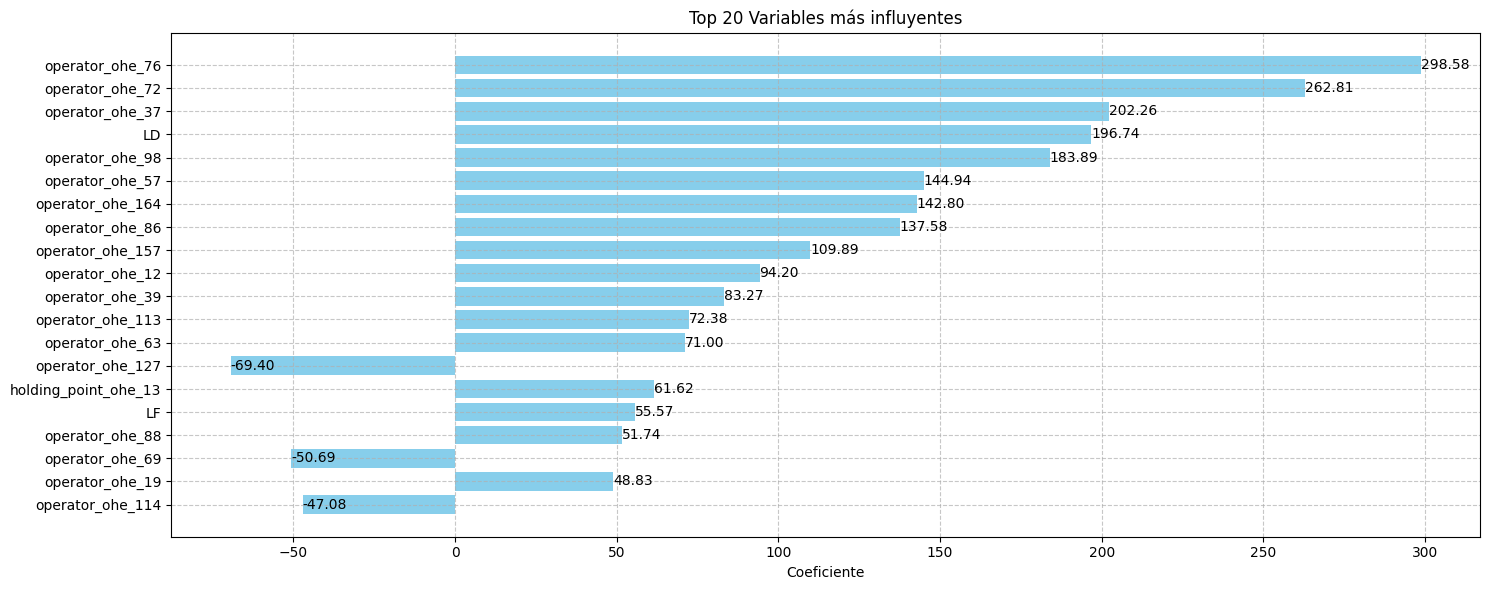

In [91]:
import matplotlib.pyplot as plt

# Seleccionar top N variables
top_n = 20
top_features = feature_importances[:top_n]

# Separar nombres y valores
names = [f[0] for f in top_features]
values = [f[1] for f in top_features]

# Crear gráfico
plt.figure(figsize=(15, 6))
bars = plt.barh(names, values, color="skyblue")
plt.xlabel("Coeficiente")
plt.title("Top 20 Variables más influyentes")
plt.gca().invert_yaxis()  # Para que la más importante esté arriba
plt.grid(True, linestyle="--", alpha=0.7)

# Añadir etiquetas con el valor
for bar, value in zip(bars, values):
    plt.text(value, bar.get_y() + bar.get_height()/2, f"{value:.2f}", va='center', ha='left')

plt.tight_layout()

# --- Guardar gráfica ---
plot_path = "top20_feature_importance_lr.png"
plt.savefig(plot_path)

plt.show()

## Registro del modelo en MLflow

In [95]:
mlflow.set_tracking_uri("file:./mlflow_experiments")
mlflow.set_experiment("takeoff_time_prediction")

with mlflow.start_run():

    # - Datos generales -

    # ========================================================================
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("framework", "pyspark.ml") # scikit-learn, tensorflow, etc.
    mlflow.set_tag("target_variable", "takeoff_time") # variable respuesta
    mlflow.set_tag("preprocessing", "StringIndexer+OneHotEncoder+StandardScaler+VectorAssembler") # transformaciones separadas por un +
    mlflow.set_tag("dataset", "original") # indicar si se ha modificado el conjunto de datos
    mlflow.set_tag("seed", SEED) # semilla para replicabilidad
    # ========================================================================
    
    # - Hiperparámetros óptimos -
    
    # =====================================
    # AÑADIR HIPERPARÁMETROS
    mlflow.log_param("model", MODEL_NAME)
    for param_name, param_value in best_result["params"].items():
        mlflow.log_param(param_name, param_value)
    # =====================================
    
    # - Métricas -

    mlflow.log_metric("execution_time_s", execution_time)

    mlflow.log_metric("mae_val", mae_val)
    mlflow.log_metric("rmse_val", rmse_val)

    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("rmse_train", rmse_train)

    # Registrar métricas globales en test
    for metric_name, value in report["global"].items():
        mlflow.log_metric(f"{metric_name}_test", value)
    
    # Registrar métricas por runway
    for runway, metrics in report["by_runway"].items():
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{metric_name}_test_runway_{runway}", value)
    
    # Registrar métricas por holding point
    for hp, metrics in report["by_holding_point"].items():
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{metric_name}_test_hp_{hp}", value)

    # - Importancia de variables -
    mlflow.log_artifact(plot_path, artifact_path="plots")

    # - Modelo -

    # ========================================================================
    # NOTA - Dependiendo de con qué has hecho el modelo esto hay que cambiarlo
    mlflow.spark.log_model(model, MODEL_NAME)
    # ========================================================================

2025/04/26 17:08:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [4]:
!mlflow ui --backend-store-uri ./mlflow_experiments

[2025-04-26 18:17:50 +0200] [205853] [INFO] Starting gunicorn 23.0.0
[2025-04-26 18:17:50 +0200] [205853] [INFO] Listening at: http://127.0.0.1:5000 (205853)
[2025-04-26 18:17:50 +0200] [205853] [INFO] Using worker: sync
[2025-04-26 18:17:50 +0200] [205854] [INFO] Booting worker with pid: 205854
[2025-04-26 18:17:50 +0200] [205855] [INFO] Booting worker with pid: 205855
[2025-04-26 18:17:50 +0200] [205856] [INFO] Booting worker with pid: 205856
[2025-04-26 18:17:50 +0200] [205857] [INFO] Booting worker with pid: 205857
[2025-04-26 18:17:59 +0200] [205853] [INFO] Handling signal: int
^C

Aborted!
[2025-04-26 18:18:00 +0200] [205855] [INFO] Worker exiting (pid: 205855)
[2025-04-26 18:18:00 +0200] [205857] [INFO] Worker exiting (pid: 205857)
[2025-04-26 18:18:00 +0200] [205856] [INFO] Worker exiting (pid: 205856)
[2025-04-26 18:18:00 +0200] [205854] [INFO] Worker exiting (pid: 205854)
